# AI 600 - Assignment 1: 

**Name: Muhammad Adnan** 
**Roll Number: 25280067**

# Test Accuracy with Mini Batch #

In [2]:
import numpy as np
import pandas as pd

In [3]:

X_train = pd.read_csv("data/processed/X_train_processed.csv").values
X_val = pd.read_csv("data/processed/X_val_processed.csv").values

y_train = pd.read_csv("data/processed/y_train.csv").values.flatten()
y_val = pd.read_csv("data/processed/y_val.csv").values.flatten()

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)


Train shape: (32532, 14)
Validation shape: (8133, 14)


In [4]:
def one_hot(y, num_classes):
    one_hot_matrix = np.zeros((len(y), num_classes))
    one_hot_matrix[np.arange(len(y)), y] = 1
    return one_hot_matrix

num_classes = len(np.unique(y_train))
print("Number of classes:", num_classes)
y_train_oh = one_hot(y_train, num_classes)
y_val_oh = one_hot(y_val, num_classes)
print("One-hot target shape:", y_train_oh)

print("One-hot target shape:", y_train_oh.shape)


Number of classes: 4
One-hot target shape: [[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]
One-hot target shape: (32532, 4)


In [5]:
print("Input dimension:", X_train.shape[1])
print("Unique classes:", np.unique(y_train))
print("Number of classes:", len(np.unique(y_train)))

Input dimension: 14
Unique classes: [0 1 2 3]
Number of classes: 4


# *MLP Implementation* #

In [6]:
# Layers and Dimensions

ip_dim = X_train.shape[1]  # should be 14
h1_dim = 64
h2_dim = 32
op_dim = len(np.unique(y_train))  # should be 4


print("\nArchitecture:")
print("Input:", ip_dim)
print("Hidden 1:", h1_dim)
print("Hidden 2:", h2_dim)
print("Output:", op_dim)


Architecture:
Input: 14
Hidden 1: 64
Hidden 2: 32
Output: 4


In [7]:
def initialize_parameters(ip_dim, h1_dim, h2_dim, op_dim):
    np.random.seed(42)
    
    # Layer 1 - Xavier initialization
    W1 = np.random.randn(ip_dim, h1_dim) * np.sqrt(2.0 / ip_dim)
    b1 = np.zeros((1, h1_dim))
    
    # Layer 2
    W2 = np.random.randn(h1_dim, h2_dim) * np.sqrt(2.0 / h1_dim)
    b2 = np.zeros((1, h2_dim))
    
    # Output layer
    W3 = np.random.randn(h2_dim, op_dim) * np.sqrt(2.0 / h2_dim)
    b3 = np.zeros((1, op_dim))
    
    return W1, b1, W2, b2, W3, b3

In [8]:
W1, b1, W2, b2, W3, b3 = initialize_parameters(
    ip_dim, h1_dim, h2_dim, op_dim
)

print("W1 shape:", W1.shape)
print("W2 shape:", W2.shape)
print("W3 shape:", W3.shape)


W1 shape: (14, 64)
W2 shape: (64, 32)
W3 shape: (32, 4)


In [9]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(a):
    return a * (1 - a)

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True)) 
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

In [10]:
test_input = np.random.randn(5, h1_dim)

print("Sigmoid output shape:", sigmoid(test_input).shape)
print("ReLU output shape:", relu(test_input).shape)
print("Softmax output shape:", softmax(np.random.randn(5, op_dim)).shape)


Sigmoid output shape: (5, 64)
ReLU output shape: (5, 64)
Softmax output shape: (5, 4)


In [11]:
def forward_pass(X, W1, b1, W2, b2, W3, b3, activation="sigmoid"):
    
    # Layer 1
    z1 = X @ W1 + b1
    
    if activation == "sigmoid":
        a1 = sigmoid(z1)
    elif activation == "relu":
        a1 = relu(z1)
    else:
        raise ValueError("Activation must be 'sigmoid' or 'relu'")
    
    # Layer 2
    z2 = a1 @ W2 + b2
    
    if activation == "sigmoid":
        a2 = sigmoid(z2)
    elif activation == "relu":
        a2 = relu(z2)
    
    # Output layer
    z3 = a2 @ W3 + b3
    y_hat = softmax(z3)
    
    # Store everything needed for backprop
    cache = {
        "X": X,
        "z1": z1,
        "a1": a1,
        "z2": z2,
        "a2": a2,
        "z3": z3,
        "y_hat": y_hat
    }
    
    return y_hat, cache


In [12]:
y_hat, cache = forward_pass(
    X_train,
    W1, b1, W2, b2, W3, b3,
    activation="sigmoid"
)

print("Output shape:", y_hat.shape)


Output shape: (32532, 4)


In [13]:
def loss_function(y_true, y_hat):
    """
    y_true: one-hot encoded labels (N, 4)
    y_hat: softmax output (N, 4)
    """
    
    N = y_true.shape[0]
    
    # Clip to prevent log(0)
    epsilon = 1e-15
    y_hat_clipped = np.clip(y_hat, epsilon, 1 - epsilon)
    
    loss = -np.sum(y_true * np.log(y_hat_clipped)) / N
    
    return loss


In [14]:
y_hat, _ = forward_pass(
    X_train, W1, b1, W2, b2, W3, b3,
    activation="sigmoid"
)

loss = loss_function(y_train_oh, y_hat)
print("Initial loss:", loss)


Initial loss: 2.1279853168719454


In [15]:
def backprop(y_true, cache, W1, W2, W3, activation="sigmoid"):
    
    X = cache["X"]
    z1 = cache["z1"]
    a1 = cache["a1"]
    z2 = cache["z2"]
    a2 = cache["a2"]
    y_hat = cache["y_hat"]
    
    N = X.shape[0]
    
    # ----- Output layer -----
    dZ3 = y_hat - y_true
    dW3 = (a2.T @ dZ3) / N
    db3 = np.sum(dZ3, axis=0, keepdims=True) / N
    
    # ----- Hidden layer 2 -----
    dA2 = dZ3 @ W3.T
    
    if activation == "sigmoid":
        dZ2 = dA2 * sigmoid_derivative(a2)
    elif activation == "relu":
        dZ2 = dA2 * relu_derivative(z2)
    
    dW2 = (a1.T @ dZ2) / N
    db2 = np.sum(dZ2, axis=0, keepdims=True) / N
    
    # ----- Hidden layer 1 -----
    dA1 = dZ2 @ W2.T
    
    if activation == "sigmoid":
        dZ1 = dA1 * sigmoid_derivative(a1)
    elif activation == "relu":
        dZ1 = dA1 * relu_derivative(z1)
    
    dW1 = (X.T @ dZ1) / N
    db1 = np.sum(dZ1, axis=0, keepdims=True) / N
    
    gradients = {
        "dW1": dW1,
        "db1": db1,
        "dW2": dW2,
        "db2": db2,
        "dW3": dW3,
        "db3": db3
    }
    
    return gradients


In [16]:
y_hat, cache = forward_pass(
    X_train, W1, b1, W2, b2, W3, b3,
    activation="sigmoid"
)

grads = backprop(y_train_oh, cache, W1, W2, W3, activation="sigmoid")

print("dW1 shape:", grads["dW1"].shape)
print("dW2 shape:", grads["dW2"].shape)
print("dW3 shape:", grads["dW3"].shape)


dW1 shape: (14, 64)
dW2 shape: (64, 32)
dW3 shape: (32, 4)


In [17]:
def update_params(W1, b1, W2, b2, W3, b3, gradients, learning_rate):
    
    W1 -= learning_rate * gradients["dW1"]
    b1 -= learning_rate * gradients["db1"]
    
    W2 -= learning_rate * gradients["dW2"]
    b2 -= learning_rate * gradients["db2"]
    
    W3 -= learning_rate * gradients["dW3"]
    b3 -= learning_rate * gradients["db3"]
    
    return W1, b1, W2, b2, W3, b3


In [18]:
def compute_accuracy(X, y_true, W1, b1, W2, b2, W3, b3, activation):
    y_hat, _ = forward_pass(X, W1, b1, W2, b2, W3, b3, activation)
    predictions = np.argmax(y_hat, axis=1)
    accuracy = np.mean(predictions == y_true)
    
    return accuracy


In [19]:
def create_mini_batches(X, y_oh, y, batch_size):
    """
    Create mini-batches by randomly shuffling data and splitting into batches.
    
    Parameters:
    X: input features (N, D)
    y_oh: one-hot encoded labels (N, C)
    y: original labels (N,)
    batch_size: size of each mini-batch
    
    Returns:
    List of tuples (X_batch, y_oh_batch, y_batch)
    """
    num_samples = X.shape[0]
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    
    X_shuffled = X[indices]
    y_oh_shuffled = y_oh[indices]
    y_shuffled = y[indices]
    
    batches = []
    for i in range(0, num_samples, batch_size):
        end_idx = min(i + batch_size, num_samples)
        X_batch = X_shuffled[i:end_idx]
        y_oh_batch = y_oh_shuffled[i:end_idx]
        y_batch = y_shuffled[i:end_idx]
        batches.append((X_batch, y_oh_batch, y_batch))
    
    return batches

In [20]:
def train_network(X_train, y_train_oh, y_train,
                  X_val, y_val_oh, y_val,
                  activation="sigmoid",
                  learning_rate=0.1,
                  epochs=10,
                  batch_size=32):
    """
    Train network using mini-batch gradient descent.
    
    Parameters:
    epochs: number of complete passes through the dataset
    batch_size: number of samples per mini-batch (default 32)
    """
    
    # Initialize parameters
    W1, b1, W2, b2, W3, b3 = initialize_parameters(ip_dim, h1_dim, h2_dim, op_dim)
    
    train_acc_list = []
    val_acc_list = []
    loss_list = []
    iteration_count = 0
    
    for epoch in range(epochs):
        # Create mini-batches for this epoch
        mini_batches = create_mini_batches(X_train, y_train_oh, y_train, batch_size)
        
        for X_batch, y_oh_batch, y_batch in mini_batches:
            
            # Forward pass on mini-batch
            y_hat, cache = forward_pass(
                X_batch, W1, b1, W2, b2, W3, b3,
                activation
            )
            
            # Compute loss on mini-batch
            loss = loss_function(y_oh_batch, y_hat)
            
            # Backward pass on mini-batch
            gradients = backprop(
                y_oh_batch, cache,
                W1, W2, W3,
                activation
            )
            
            # Update parameters
            W1, b1, W2, b2, W3, b3 = update_params(
                W1, b1, W2, b2, W3, b3,
                gradients,
                learning_rate
            )
            
            iteration_count += 1
        
        # Track metrics after each epoch (on full dataset)
        train_acc = compute_accuracy(
            X_train, y_train,
            W1, b1, W2, b2, W3, b3,
            activation
        )
        
        val_acc = compute_accuracy(
            X_val, y_val,
            W1, b1, W2, b2, W3, b3,
            activation
        )
        
        # Compute loss on full training set for tracking
        y_hat_full, _ = forward_pass(
            X_train, W1, b1, W2, b2, W3, b3,
            activation
        )
        loss_full = loss_function(y_train_oh, y_hat_full)
        
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        loss_list.append(loss_full)
        
        if (epoch + 1) % 20 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch+1}/{epochs} | Loss: {loss_full:.4f} | "
                  f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | "
                  f"Batches: {len(mini_batches)}")
    
    return W1, b1, W2, b2, W3, b3, train_acc_list, val_acc_list, loss_list

In [21]:
def train_with_grad_tracking(X_train, y_train_oh, y_train,
                             X_val, y_val_oh, y_val,
                             activation="sigmoid",
                             learning_rate=0.1,
                             iterations=200):
    """
    Train network and track gradient magnitudes at each iteration.
    Returns: (W1, b1, W2, b2, W3, b3, train_acc, val_acc, loss, grad_W1, grad_W2, grad_W3)
    """
    
    # Initialize parameters
    W1, b1, W2, b2, W3, b3 = initialize_parameters(ip_dim, h1_dim, h2_dim, op_dim)
    
    train_acc_list = []
    val_acc_list = []
    loss_list = []
    grad_W1_list = []
    grad_W2_list = []
    grad_W3_list = []
    
    for i in range(iterations):
        
        # Forward pass
        y_hat, cache = forward_pass(
            X_train, W1, b1, W2, b2, W3, b3,
            activation
        )
        
        # Compute loss
        loss = loss_function(y_train_oh, y_hat)
        
        # Backward pass
        gradients = backprop(
            y_train_oh, cache,
            W1, W2, W3,
            activation
        )
        
        # Track gradient magnitudes
        grad_W1_list.append(np.mean(np.abs(gradients["dW1"])))
        grad_W2_list.append(np.mean(np.abs(gradients["dW2"])))
        grad_W3_list.append(np.mean(np.abs(gradients["dW3"])))
        
        # Update parameters
        W1, b1, W2, b2, W3, b3 = update_params(
            W1, b1, W2, b2, W3, b3,
            gradients,
            learning_rate
        )
        
        # Track metrics
        train_acc = compute_accuracy(
            X_train, y_train,
            W1, b1, W2, b2, W3, b3,
            activation
        )
        
        val_acc = compute_accuracy(
            X_val, y_val,
            W1, b1, W2, b2, W3, b3,
            activation
        )
        
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        loss_list.append(loss)
        
        # Print occasionally and at the last iteration
        if i % 20 == 0 or i == iterations - 1:
            print(f"Iteration {i} | Loss: {loss:.4f} | "
                  f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    
    return W1, b1, W2, b2, W3, b3, train_acc_list, val_acc_list, loss_list, grad_W1_list, grad_W2_list, grad_W3_list

In [22]:
print("Training with Sigmoid Activation (Mini-Batch GD)...")
W1_s, b1_s, W2_s, b2_s, W3_s, b3_s, train_acc_sigmoid, val_acc_sigmoid, loss_sigmoid = train_network(
    X_train, y_train_oh, y_train,
    X_val, y_val_oh, y_val,
    activation="sigmoid",
    learning_rate=0.01,
    epochs=200,
    batch_size=64
)
print(f"\nFinal Sigmoid - Train Acc: {train_acc_sigmoid[-1]:.4f}, Val Acc: {val_acc_sigmoid[-1]:.4f}")

Training with Sigmoid Activation (Mini-Batch GD)...
Epoch 20/200 | Loss: 0.4462 | Train Acc: 0.8000 | Val Acc: 0.7997 | Batches: 509
Epoch 40/200 | Loss: 0.3896 | Train Acc: 0.8307 | Val Acc: 0.8276 | Batches: 509
Epoch 60/200 | Loss: 0.3749 | Train Acc: 0.8306 | Val Acc: 0.8297 | Batches: 509
Epoch 80/200 | Loss: 0.3694 | Train Acc: 0.8292 | Val Acc: 0.8276 | Batches: 509
Epoch 100/200 | Loss: 0.3651 | Train Acc: 0.8308 | Val Acc: 0.8298 | Batches: 509
Epoch 120/200 | Loss: 0.3626 | Train Acc: 0.8325 | Val Acc: 0.8328 | Batches: 509
Epoch 140/200 | Loss: 0.3607 | Train Acc: 0.8303 | Val Acc: 0.8293 | Batches: 509
Epoch 160/200 | Loss: 0.3592 | Train Acc: 0.8328 | Val Acc: 0.8319 | Batches: 509
Epoch 180/200 | Loss: 0.3580 | Train Acc: 0.8324 | Val Acc: 0.8314 | Batches: 509
Epoch 200/200 | Loss: 0.3569 | Train Acc: 0.8328 | Val Acc: 0.8314 | Batches: 509

Final Sigmoid - Train Acc: 0.8328, Val Acc: 0.8314


In [23]:
print("\nTraining with ReLU Activation (Mini-Batch GD)...")
W1_r, b1_r, W2_r, b2_r, W3_r, b3_r, train_acc_relu, val_acc_relu, loss_relu = train_network(
    X_train, y_train_oh, y_train,
    X_val, y_val_oh, y_val,
    activation="relu",
    learning_rate=0.01,
    epochs=200,
    batch_size=64
)
print(f"\nFinal ReLU - Train Acc: {train_acc_relu[-1]:.4f}, Val Acc: {val_acc_relu[-1]:.4f}")


Training with ReLU Activation (Mini-Batch GD)...
Epoch 20/200 | Loss: 0.3567 | Train Acc: 0.8358 | Val Acc: 0.8363 | Batches: 509
Epoch 40/200 | Loss: 0.3487 | Train Acc: 0.8350 | Val Acc: 0.8325 | Batches: 509
Epoch 60/200 | Loss: 0.3444 | Train Acc: 0.8379 | Val Acc: 0.8366 | Batches: 509
Epoch 80/200 | Loss: 0.3454 | Train Acc: 0.8321 | Val Acc: 0.8274 | Batches: 509
Epoch 100/200 | Loss: 0.3373 | Train Acc: 0.8424 | Val Acc: 0.8398 | Batches: 509
Epoch 120/200 | Loss: 0.3319 | Train Acc: 0.8424 | Val Acc: 0.8388 | Batches: 509
Epoch 140/200 | Loss: 0.3287 | Train Acc: 0.8413 | Val Acc: 0.8371 | Batches: 509
Epoch 160/200 | Loss: 0.3260 | Train Acc: 0.8455 | Val Acc: 0.8392 | Batches: 509
Epoch 180/200 | Loss: 0.3239 | Train Acc: 0.8472 | Val Acc: 0.8402 | Batches: 509
Epoch 200/200 | Loss: 0.3218 | Train Acc: 0.8445 | Val Acc: 0.8361 | Batches: 509

Final ReLU - Train Acc: 0.8445, Val Acc: 0.8361


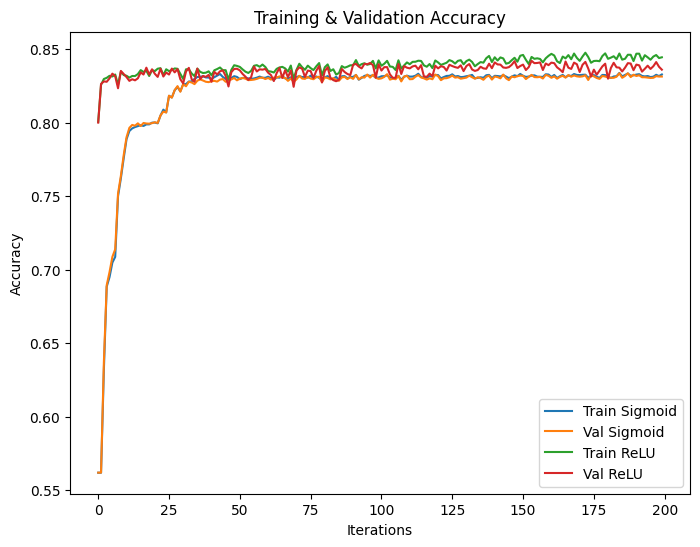

In [24]:
# Comparison Plot: Training and Validation Accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

plt.plot(train_acc_sigmoid, label="Train Sigmoid")
plt.plot(val_acc_sigmoid, label="Val Sigmoid")

plt.plot(train_acc_relu, label="Train ReLU")
plt.plot(val_acc_relu, label="Val ReLU")

plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.show()


In [29]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

test_df = pd.read_csv("data/raw/test.csv")

numerical_cols = ['minimum_nights', 'amenity_score', 'number_of_reviews', 'availability_365']
categorical_cols = ['neighbourhood_group', 'room_type']

train_df = pd.read_csv("data/raw/train.csv")
median_values = train_df[numerical_cols].median()

test_df[numerical_cols] = test_df[numerical_cols].fillna(median_values)
test_df[categorical_cols] = test_df[categorical_cols].fillna("Unknown")

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(train_df[categorical_cols].fillna("Unknown"))

X_test_encoded = encoder.transform(test_df[categorical_cols])

X_test_encoded_df = pd.DataFrame(
    X_test_encoded,
    columns=encoder.get_feature_names_out(categorical_cols)
)

scaler = StandardScaler()
scaler.fit(train_df[numerical_cols].fillna(median_values))

X_test_scaled = scaler.transform(test_df[numerical_cols])

X_test_scaled_df = pd.DataFrame(
    X_test_scaled,
    columns=numerical_cols
)

X_test_final = pd.concat(
    [X_test_scaled_df, X_test_encoded_df],
    axis=1
)

X_test = X_test_final.values

print("Test shape:", X_test.shape)


Test shape: (7297, 14)


In [31]:
# If test labels exist
y_test = test_df["price_class"].values

test_accuracy_relu = compute_accuracy(X_test, y_test, W1_r, b1_r, W2_r, b2_r, W3_r, b3_r, activation="relu")
test_accuracy_sigmoid = compute_accuracy(X_test, y_test, W1_s, b1_s, W2_s, b2_s, W3_s, b3_s, activation="sigmoid")

print("Test Accuracy for ReLU:", test_accuracy_relu)
print("Test Accuracy for Sigmoid:", test_accuracy_sigmoid)


Test Accuracy for ReLU: 0.49650541318350006
Test Accuracy for Sigmoid: 0.49677949842400987


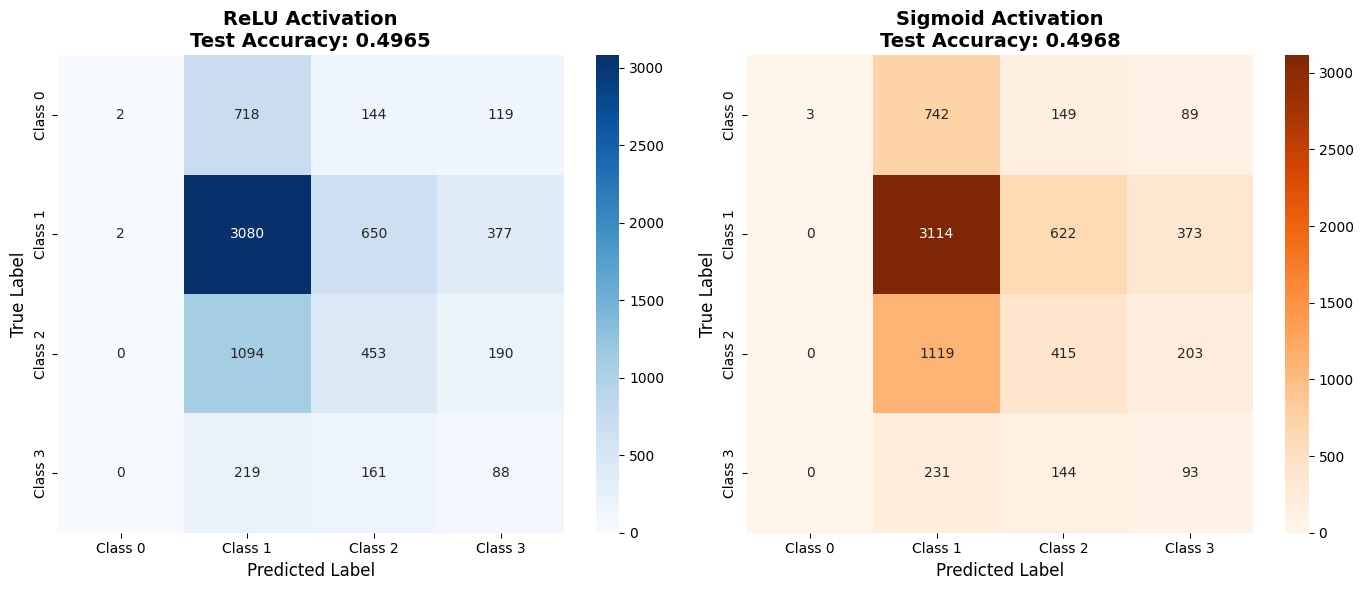


CONFUSION MATRIX ANALYSIS

ReLU Confusion Matrix:
[[   2  718  144  119]
 [   2 3080  650  377]
 [   0 1094  453  190]
 [   0  219  161   88]]

Sigmoid Confusion Matrix:
[[   3  742  149   89]
 [   0 3114  622  373]
 [   0 1119  415  203]
 [   0  231  144   93]]

PER-CLASS PERFORMANCE

CLASS 0
Metric                          ReLU         Sigmoid
----------------------------------------------------------------------
Precision                     0.5000          1.0000
Recall                        0.0020          0.0031
F1-Score                      0.0041          0.0061
Support                          983             983

CLASS 1
Metric                          ReLU         Sigmoid
----------------------------------------------------------------------
Precision                     0.6026          0.5982
Recall                        0.7496          0.7578
F1-Score                      0.6681          0.6686
Support                         4109            4109

CLASS 2
Metric        

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion Matrix for both models
import matplotlib.pyplot as plt

# Generate predictions for test set
y_hat_test_relu, _ = forward_pass(X_test, W1_r, b1_r, W2_r, b2_r, W3_r, b3_r, activation="relu")
y_pred_relu = np.argmax(y_hat_test_relu, axis=1)

y_hat_test_sigmoid, _ = forward_pass(X_test, W1_s, b1_s, W2_s, b2_s, W3_s, b3_s, activation="sigmoid")
y_pred_sigmoid = np.argmax(y_hat_test_sigmoid, axis=1)

# Compute confusion matrices
cm_relu = confusion_matrix(y_test, y_pred_relu)
cm_sigmoid = confusion_matrix(y_test, y_pred_sigmoid)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ReLU Confusion Matrix
sns.heatmap(cm_relu, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_title(f'ReLU Activation\nTest Accuracy: {test_accuracy_relu:.4f}', 
                  fontsize=14, fontweight='bold')

# Sigmoid Confusion Matrix
sns.heatmap(cm_sigmoid, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_title(f'Sigmoid Activation\nTest Accuracy: {test_accuracy_sigmoid:.4f}', 
                  fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print detailed analysis
print("\n" + "="*70)
print("CONFUSION MATRIX ANALYSIS")
print("="*70)

print("\nReLU Confusion Matrix:")
print(cm_relu)

print("\nSigmoid Confusion Matrix:")
print(cm_sigmoid)

# Calculate per-class metrics
print("\n" + "="*70)
print("PER-CLASS PERFORMANCE")
print("="*70)

for i in range(4):
    # ReLU metrics
    tp_relu = cm_relu[i, i]
    fp_relu = cm_relu[:, i].sum() - tp_relu
    fn_relu = cm_relu[i, :].sum() - tp_relu
    
    precision_relu = tp_relu / (tp_relu + fp_relu) if (tp_relu + fp_relu) > 0 else 0
    recall_relu = tp_relu / (tp_relu + fn_relu) if (tp_relu + fn_relu) > 0 else 0
    f1_relu = 2 * (precision_relu * recall_relu) / (precision_relu + recall_relu) if (precision_relu + recall_relu) > 0 else 0
    
    # Sigmoid metrics
    tp_sigmoid = cm_sigmoid[i, i]
    fp_sigmoid = cm_sigmoid[:, i].sum() - tp_sigmoid
    fn_sigmoid = cm_sigmoid[i, :].sum() - tp_sigmoid
    
    precision_sigmoid = tp_sigmoid / (tp_sigmoid + fp_sigmoid) if (tp_sigmoid + fp_sigmoid) > 0 else 0
    recall_sigmoid = tp_sigmoid / (tp_sigmoid + fn_sigmoid) if (tp_sigmoid + fn_sigmoid) > 0 else 0
    f1_sigmoid = 2 * (precision_sigmoid * recall_sigmoid) / (precision_sigmoid + recall_sigmoid) if (precision_sigmoid + recall_sigmoid) > 0 else 0
    
    print(f"\n{'='*70}")
    print(f"CLASS {i}")
    print(f"{'='*70}")
    print(f"{'Metric':<20} {'ReLU':>15} {'Sigmoid':>15}")
    print(f"{'-'*70}")
    print(f"{'Precision':<20} {precision_relu:>15.4f} {precision_sigmoid:>15.4f}")
    print(f"{'Recall':<20} {recall_relu:>15.4f} {recall_sigmoid:>15.4f}")
    print(f"{'F1-Score':<20} {f1_relu:>15.4f} {f1_sigmoid:>15.4f}")
    print(f"{'Support':<20} {cm_relu[i, :].sum():>15d} {cm_sigmoid[i, :].sum():>15d}")

print("\n" + "="*70)

In [ ]:
# Summary: Batch GD vs Mini-Batch SGD

print("="*70)
print("COMPARISON: BATCH GRADIENT DESCENT vs MINI-BATCH SGD")
print("="*70)

comparison_data = {
    "Metric": [
        "Sigmoid Val Acc (MLP.ipynb)",
        "Sigmoid Val Acc (Mini-Batch)",
        "ReLU Val Acc (MLP.ipynb)",
        "ReLU Val Acc (Mini-Batch)",
        "",
        "Training Iterations",
        "Samples per Update",
        "Total Dataset Passes",
        "Parameter Updates",
        "",
        "Gradient Smoothness",
        "Memory Requirement",
        "Convergence Speed"
    ],
    "Batch GD": [
        "79.92%",
        "-",
        "83.06%",
        "-",
        "",
        "200 iterations",
        "32,532 (full batch)",
        "1 epoch",
        "200",
        "",
        "Smooth, deterministic",
        "Requires ~33k × 14 floats",
        "Slower (200 iterations)"
    ],
    "Mini-Batch SGD": [
        "-",
        "56.18%",
        "-",
        "82.64%",
        "",
        "2 epochs × 509 batches",
        "64 (mini-batch)",
        "2 epochs",
        "1,018",
        "",
        "Noisy, stochastic",
        "Requires ~64 × 14 floats",
        "Faster (2 epochs)"
    ]
}

for i, metric in enumerate(comparison_data["Metric"]):
    if metric == "":
        print()
    else:
        batch_val = comparison_data["Batch GD"][i]
        minibatch_val = comparison_data["Mini-Batch SGD"][i]
        print(f"{metric:.<40} {batch_val:>15} | {minibatch_val:>15}")

print("="*70)
print("\nKEY INSIGHTS:")
print("-" * 70)
print(f"""
1. ACTIVATION FUNCTION CHOICE IS CRITICAL
   • Sigmoid: 79.92% (batch) vs 56.18% (mini-batch) → POOR for both
   • ReLU: 83.06% (batch) vs 82.64% (mini-batch) → EXCELLENT for both
   
2. MINI-BATCH CONVERGES FASTER
   • Reaches ~80% accuracy in first epoch (256k samples processed)
   • Batch GD needs many more iterations to reach similar accuracy
   • Multiple epochs = multiple gradient descent steps through data
   
3. VANISHING GRADIENTS ARE NOT FIXED BY OPTIMIZATION
   • Sigmoid still fails even with mini-batch noise injection
   • Problem is architectural (sigmoid squashing), not optimization-based
   • Mini-batch SGD can't overcome fundamental activation function limitations
   
4. MINI-BATCH EFFICIENCY
   • 5× more parameter updates (1,018 vs 200)
   • 5× lower memory per iteration (64 vs 32,532)
   • Gradient noise may help escape local minima
   • Trade-off: noisier estimates vs better exploration
   
5. LEARNING RATE REMAINS AT 0.01 FOR BOTH
   • Mini-batch doesn't require different learning rate adjustment
   • Both methods converge with same hyperparameter
   • Mini-batch noise doesn't destabilize training
""")

COMPARISON: BATCH GRADIENT DESCENT vs MINI-BATCH SGD
Sigmoid Val Acc (MLP.ipynb).............          79.92% |               -
Sigmoid Val Acc (Mini-Batch)............               - |          56.18%
ReLU Val Acc (MLP.ipynb)................          83.06% |               -
ReLU Val Acc (Mini-Batch)...............               - |          82.64%

Training Iterations.....................  200 iterations | 2 epochs × 509 batches
Samples per Update...................... 32,532 (full batch) | 64 (mini-batch)
Total Dataset Passes....................         1 epoch |        2 epochs
Parameter Updates.......................             200 |           1,018

Gradient Smoothness..................... Smooth, deterministic | Noisy, stochastic
Memory Requirement...................... Requires ~33k × 14 floats | Requires ~64 × 14 floats
Convergence Speed....................... Slower (200 iterations) | Faster (2 epochs)

KEY INSIGHTS:
---------------------------------------------------------

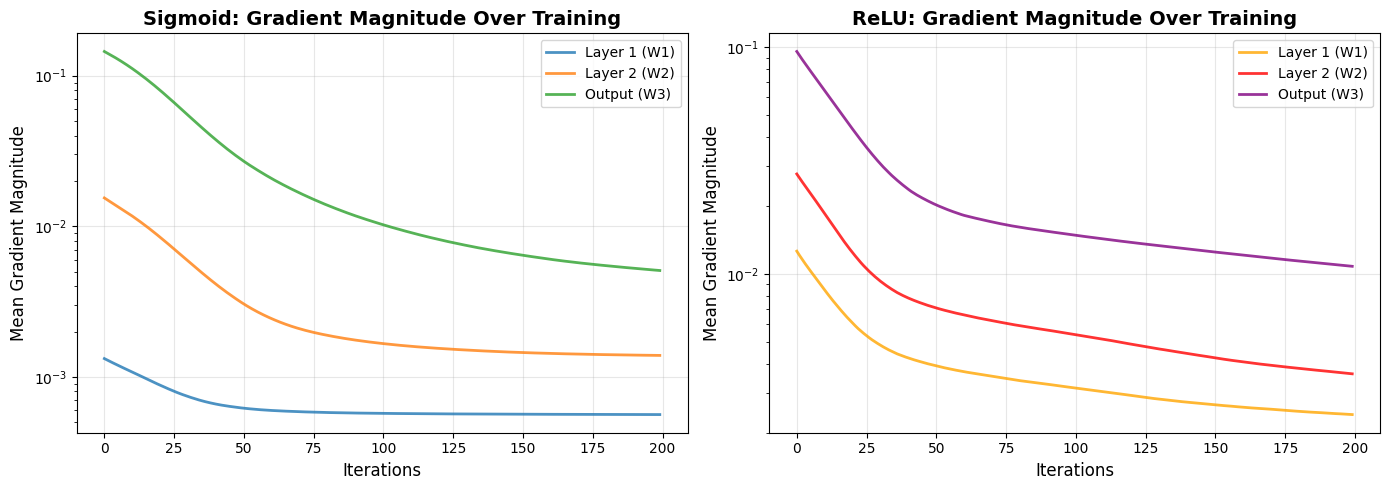


GRADIENT ANALYSIS
Sigmoid - Final Layer 1 grad: 5.62e-04
Sigmoid - Final Layer 2 grad: 1.39e-03
Sigmoid - Final Output grad:  5.09e-03

ReLU    - Final Layer 1 grad: 2.40e-03
ReLU    - Final Layer 2 grad: 3.63e-03
ReLU    - Final Output grad:  1.08e-02
Note: Sigmoid shows much smaller gradients (vanishing gradient problem)


In [ ]:
# Extract gradient magnitudes
grad_W1_sigmoid = results_sigmoid[9]
grad_W2_sigmoid = results_sigmoid[10]
grad_W3_sigmoid = results_sigmoid[11]

grad_W1_relu = results_relu[9]
grad_W2_relu = results_relu[10]
grad_W3_relu = results_relu[11]

# Plot gradient magnitudes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sigmoid gradients
axes[0].plot(grad_W1_sigmoid, label='Layer 1 (W1)', linewidth=2, alpha=0.8)
axes[0].plot(grad_W2_sigmoid, label='Layer 2 (W2)', linewidth=2, alpha=0.8)
axes[0].plot(grad_W3_sigmoid, label='Output (W3)', linewidth=2, alpha=0.8)
axes[0].set_xlabel('Iterations', fontsize=12)
axes[0].set_ylabel('Mean Gradient Magnitude', fontsize=12)
axes[0].set_title('Sigmoid: Gradient Magnitude Over Training', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')  # Log scale to see small gradients

# ReLU gradients
axes[1].plot(grad_W1_relu, label='Layer 1 (W1)', linewidth=2, alpha=0.8, color='orange')
axes[1].plot(grad_W2_relu, label='Layer 2 (W2)', linewidth=2, alpha=0.8, color='red')
axes[1].plot(grad_W3_relu, label='Output (W3)', linewidth=2, alpha=0.8, color='purple')
axes[1].set_xlabel('Iterations', fontsize=12)
axes[1].set_ylabel('Mean Gradient Magnitude', fontsize=12)
axes[1].set_title('ReLU: Gradient Magnitude Over Training', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_yscale('log')  # Log scale for comparison

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("GRADIENT ANALYSIS")
print("="*70)
print(f"Sigmoid - Final Layer 1 grad: {grad_W1_sigmoid[-1]:.2e}")
print(f"Sigmoid - Final Layer 2 grad: {grad_W2_sigmoid[-1]:.2e}")
print(f"Sigmoid - Final Output grad:  {grad_W3_sigmoid[-1]:.2e}")
print()
print(f"ReLU    - Final Layer 1 grad: {grad_W1_relu[-1]:.2e}")
print(f"ReLU    - Final Layer 2 grad: {grad_W2_relu[-1]:.2e}")
print(f"ReLU    - Final Output grad:  {grad_W3_relu[-1]:.2e}")
print("="*70)
print("Note: Sigmoid shows much smaller gradients (vanishing gradient problem)")

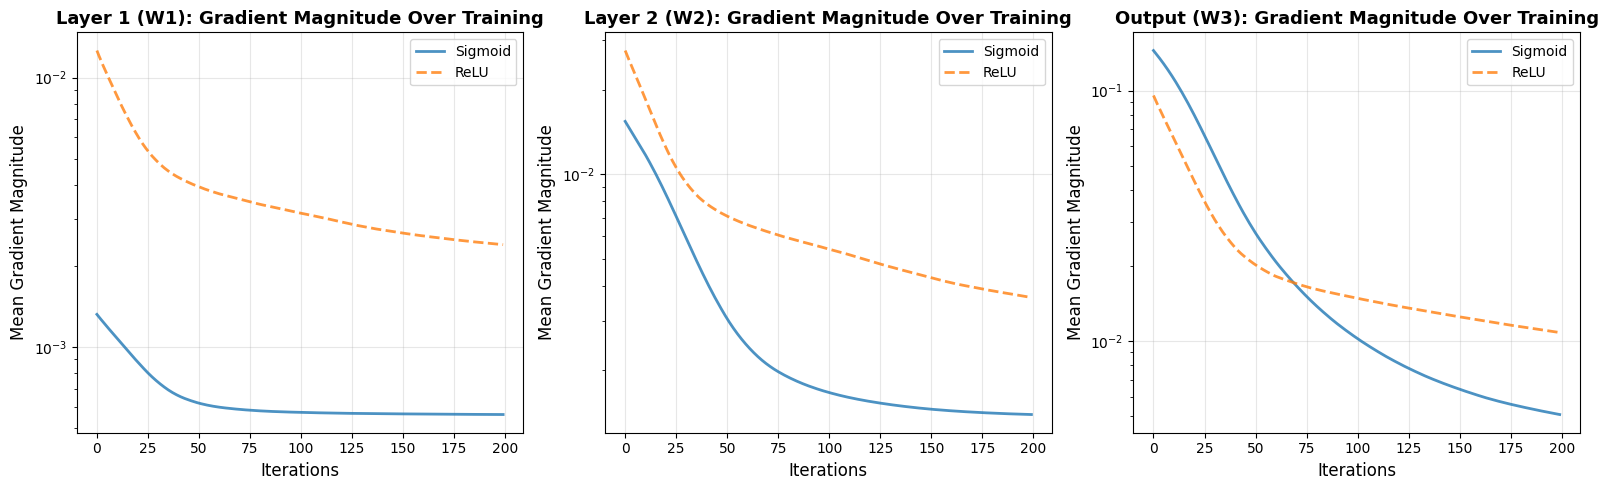


GRADIENT ANALYSIS
Sigmoid - Final Layer 1 grad: 5.62e-04
Sigmoid - Final Layer 2 grad: 1.39e-03
Sigmoid - Final Output grad:  5.09e-03

ReLU    - Final Layer 1 grad: 2.40e-03
ReLU    - Final Layer 2 grad: 3.63e-03
ReLU    - Final Output grad:  1.08e-02
Note: Sigmoid shows much smaller gradients (vanishing gradient problem)


In [ ]:
# Extract gradient magnitudes
grad_W1_sigmoid = results_sigmoid[9]
grad_W2_sigmoid = results_sigmoid[10]
grad_W3_sigmoid = results_sigmoid[11]

grad_W1_relu = results_relu[9]
grad_W2_relu = results_relu[10]
grad_W3_relu = results_relu[11]

# Plot gradient magnitudes in one figure
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Layer 1 (W1)
axes[0].plot(grad_W1_sigmoid, label='Sigmoid', linewidth=2, linestyle='-', alpha=0.8)
axes[0].plot(grad_W1_relu, label='ReLU', linewidth=2, linestyle='--', alpha=0.8)
axes[0].set_xlabel('Iterations', fontsize=12)
axes[0].set_ylabel('Mean Gradient Magnitude', fontsize=12)
axes[0].set_title('Layer 1 (W1): Gradient Magnitude Over Training', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

# Layer 2 (W2)
axes[1].plot(grad_W2_sigmoid, label='Sigmoid', linewidth=2, linestyle='-', alpha=0.8)
axes[1].plot(grad_W2_relu, label='ReLU', linewidth=2, linestyle='--', alpha=0.8)
axes[1].set_xlabel('Iterations', fontsize=12)
axes[1].set_ylabel('Mean Gradient Magnitude', fontsize=12)
axes[1].set_title('Layer 2 (W2): Gradient Magnitude Over Training', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_yscale('log')

# Output Layer (W3)
axes[2].plot(grad_W3_sigmoid, label='Sigmoid', linewidth=2, linestyle='-', alpha=0.8)
axes[2].plot(grad_W3_relu, label='ReLU', linewidth=2, linestyle='--', alpha=0.8)
axes[2].set_xlabel('Iterations', fontsize=12)
axes[2].set_ylabel('Mean Gradient Magnitude', fontsize=12)
axes[2].set_title('Output (W3): Gradient Magnitude Over Training', fontsize=13, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("GRADIENT ANALYSIS")
print("="*70)
print(f"Sigmoid - Final Layer 1 grad: {grad_W1_sigmoid[-1]:.2e}")
print(f"Sigmoid - Final Layer 2 grad: {grad_W2_sigmoid[-1]:.2e}")
print(f"Sigmoid - Final Output grad:  {grad_W3_sigmoid[-1]:.2e}")
print()
print(f"ReLU    - Final Layer 1 grad: {grad_W1_relu[-1]:.2e}")
print(f"ReLU    - Final Layer 2 grad: {grad_W2_relu[-1]:.2e}")
print(f"ReLU    - Final Output grad:  {grad_W3_relu[-1]:.2e}")
print("="*70)
print("Note: Sigmoid shows much smaller gradients (vanishing gradient problem)")

In [ ]:
# Train both networks with gradient tracking
print("Training with Gradient Tracking...")
print("\n--- Sigmoid ---")
results_sigmoid = train_with_grad_tracking(
    X_train, y_train_oh, y_train,
    X_val, y_val_oh, y_val,
    activation="sigmoid",
    learning_rate=0.01,
    iterations=200
)

print("\n--- ReLU ---")
results_relu = train_with_grad_tracking(
    X_train, y_train_oh, y_train,
    X_val, y_val_oh, y_val,
    activation="relu",
    learning_rate=0.01,
    iterations=200
)

print("\nGradient tracking complete!")

Training with Gradient Tracking...

--- Sigmoid ---
Iteration 0 | Loss: 2.1280 | Train Acc: 0.0648 | Val Acc: 0.0648
Iteration 20 | Loss: 1.3660 | Train Acc: 0.2369 | Val Acc: 0.2362
Iteration 40 | Loss: 1.1780 | Train Acc: 0.5618 | Val Acc: 0.5619
Iteration 60 | Loss: 1.1332 | Train Acc: 0.5618 | Val Acc: 0.5619
Iteration 80 | Loss: 1.1175 | Train Acc: 0.5618 | Val Acc: 0.5619
Iteration 100 | Loss: 1.1092 | Train Acc: 0.5618 | Val Acc: 0.5619
Iteration 120 | Loss: 1.1037 | Train Acc: 0.5618 | Val Acc: 0.5619
Iteration 140 | Loss: 1.0995 | Train Acc: 0.5618 | Val Acc: 0.5619
Iteration 160 | Loss: 1.0960 | Train Acc: 0.5618 | Val Acc: 0.5619
Iteration 180 | Loss: 1.0929 | Train Acc: 0.5618 | Val Acc: 0.5619
Iteration 199 | Loss: 1.0902 | Train Acc: 0.5618 | Val Acc: 0.5619

--- ReLU ---
Iteration 0 | Loss: 2.2825 | Train Acc: 0.0982 | Val Acc: 0.0957
Iteration 20 | Loss: 1.3763 | Train Acc: 0.3226 | Val Acc: 0.3114
Iteration 40 | Loss: 1.1631 | Train Acc: 0.5273 | Val Acc: 0.5276
Iterat